# Cloud points view of a mesh


### Twitter Driven Developement 

So Christophe Leterier[@christlet](https://twitter.com/christlet) and Felix Voilzel [@Flexi23](https://twitter.com/Flexi23) made this:

<blockquote class="twitter-tweet" data-partner="tweetdeck"><p lang="en" dir="ltr">I gave data to <a href="https://twitter.com/Flexi23">@Flexi23</a> and he developed... a SMLM 3D viewer in your web browser! This is excellencredible <a href="https://t.co/pTqUGlXVV6">pic.twitter.com/pTqUGlXVV6</a></p>&mdash; Christophe Leterrier (@christlet) <a href="https://twitter.com/christlet/status/791642533059293184">October 27, 2016</a></blockquote>
<script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>


![Actin filaments point cloud with Felix tool](https://pbs.twimg.com/media/Cvx6YT4WgAArHeH.jpg)

Now I have to try to generate a point cloud along the edges to simulate STORM images.


### Why?

Having a point based representation is not as futile as it sounds.

1. The file format is very simple (three columns), so easy to pass on
2. The point positions and densities can encode a lot of information
3. For our biology models, it is a straightforward route to reproducing 
   the images obtained from fluorescence microscopy, by simulating the
   (putative) distribution of a fluorescent markers
4. Thinking in terms of density fields is exciting



### Loading a tyssue dataset 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
try:
    import seaborn as sns
except ImportError:
    print('Seaborn not found - install it for neater graphs')

from tyssue.io import hdf5
from tyssue import Sheet, PlanarGeometry as geom
from tyssue import config, Monolayer
from tyssue.core import generation
from tyssue.draw.plt_draw import quick_edge_draw

from tyssue.io.csv import write_storm_csv
from tyssue.particles.point_cloud import EdgeSubdiv, FaceGrid, get_edge_bases

In [2]:
datasets = hdf5.load_datasets('../data/hf5/small_ellipsoid.hf5',
                              data_names=['vert', 'edge',
                                          'face', 'cell'])
specs = config.geometry.bulk_spec()

monolayer = Monolayer('ell', datasets, specs)
monolayer.reset_index()
monolayer.reset_topo()


## Generating particles from the edges


The idea is to simulate a STORM experiment, assuming our fluorophore is distributed along the edges.

Given the edge from the vertex at $\mathbf{r}_i$ to the one at $\mathbf{r}_j$, the possible positions of the particles are given by:

$$\mathbf{u}(s_{ij}) = \mathbf{r}_i + \mathbf{r}_{ij} s_{ij}, \quad s \in [0, 1]$$

Let $\delta_s$ be the spacing between two fluorphores, then we have $n_{ij} = \ell_{ij}/\delta_s$ fluorophores per edge.  
 

In [3]:
# Average number of particle by half-edge
density = 60
monolayer.edge_df['density'] = density
# Increase points density in the apical and basal layers
monolayer.edge_df.loc[monolayer.apical_edges, 'density'] *= 10.
monolayer.edge_df.loc[monolayer.basal_edges, 'density'] *= 10.

subdiv = EdgeSubdiv(monolayer.edge_df[['length', 'density']])
subdiv.specs['noise'] = 0.0
srce_pos = monolayer.upcast_srce(monolayer.vert_df[monolayer.coords])
r_ij = monolayer.edge_df[monolayer.dcoords]
subdiv.edge_point_cloud(srce_pos, r_ij)
subdiv.points.head()

,upcaster,offset,x,y,z
0,0,0.000874,0.513575,-0.034147,-0.985141
1,0,0.002622,0.513733,-0.033656,-0.985076
2,0,0.004371,0.513892,-0.033164,-0.985010
3,0,0.006119,0.514050,-0.032672,-0.984945
4,0,0.007867,0.514209,-0.032180,-0.984880


In [4]:
subdiv.edge_df.loc[monolayer.sagittal_edges].head()

,length,density,norm_length,num_particles,x,dx,y,dy,z,dz
edge,,,,,,,,,,
552,0.297880,60.0,0.954132,57,0.604199,-0.090703,0.246878,-0.281272,-0.947867,-0.037306
553,0.539019,60.0,1.726516,104,0.513495,-0.288569,-0.034393,0.088556,-0.985173,0.446573
554,0.069622,60.0,0.223003,13,0.224926,0.018956,0.054163,0.065282,-0.538601,0.015038
555,0.571053,60.0,1.829123,110,0.243883,0.360316,0.119445,0.127434,-0.523563,-0.424304
556,0.294302,60.0,0.942669,57,0.743104,-0.138905,0.290125,-0.043246,-0.692038,-0.255829


In [5]:
subdiv.n_edges, subdiv.n_points

(1656, 314738)

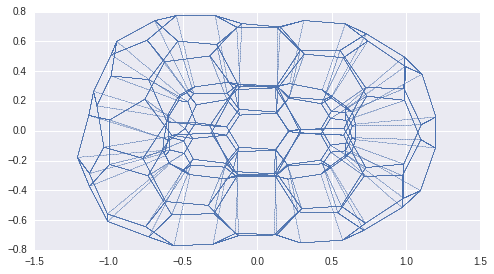

In [6]:
fig, ax = plt.subplots()
ax.plot(*subdiv.points[['z', 'x']].T.values, '.', ms=2., alpha=0.1)
ax.set_aspect('equal')


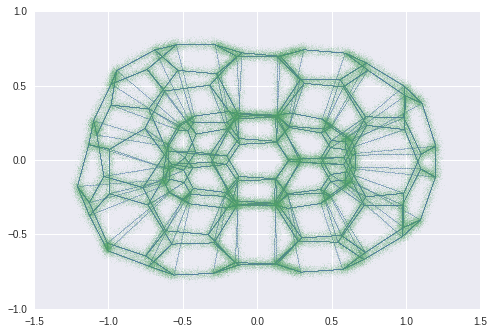

In [7]:
subdiv.specs['noise'] = 0.02
subdiv.edge_point_cloud(srce_pos, r_ij)
#fig, ax = plt.subplots()
ax.plot(*subdiv.points[['z', 'x']].T.values, '.', ms=2., alpha=0.1)
ax.set_aspect('equal')
fig

#### Modulating point density

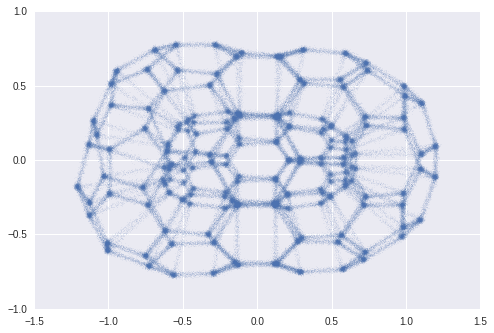

In [8]:
subdiv.specs['noise'] = 0.01

# The function defined bellow can be passed to the
# edge_point_cloud method
def gamma_modulation(subdiv, gamma=1):
    return (subdiv.points['offset']**gamma).values

gamma = 3.

subdiv.edge_point_cloud(srce_pos, r_ij,
                        gamma_modulation,
                        {'gamma': gamma})

fig, ax = plt.subplots()
ax.plot(*subdiv.points[['z', 'x']].T.values, '.', ms=2., alpha=0.08)
ax.set_aspect('equal')


In [9]:
## This is much slower, switch draw_scatter to execute
draw_scatter = False
if draw_scatter:
    fig, ax = plt.subplots()
    ax.scatter(subdiv.points.z.values,
               subdiv.points.x.values,
               marker='.', 
               s=subdiv.points.y.values*10,
               cmap='viridis',
               alpha=0.01)

    ax.set_aspect('equal')


### The 3D Storm format

Here is a screen shot of the file provided by Christophe:



![Crop of the 3D_STORM format in a tabulator](../data/png/3D_STORM_format.png)

In [10]:
### Configuration of the csv file format
csv_args = {'index':False, 'header':True, 'sep':'\t'}

subdiv.points['segment'] = monolayer.edge_df.loc[subdiv.points['upcaster'],
                                                 'segment'].values

filename = '../data/csv/ellipsoid'
rewrite = False
if rewrite:
    write_storm_csv(filename, subdiv.points,
                    coords=['x', 'y', 'z'],
                    split_by=None, **csv_args)

In [11]:
ls -lht ../data/csv/

total 111M
-rw-rw-r-- 1 guillaume guillaume 2,0M nov.  18 13:57 ellipsoid_cell_axes.csv
-rw-rw-r-- 1 guillaume guillaume 7,6M nov.  18 13:49 ellipsoid_apical_actin.csv
-rw-rw-r-- 1 guillaume guillaume 903K nov.  16 14:43 ellipsoid_apical_faces.csv
-rw-rw-r-- 1 guillaume guillaume  21M nov.   9 18:20 ellipsoid.csv
-rw-rw-r-- 1 guillaume guillaume  42M nov.   9 08:51 ellipsoid_faces.csv
-rw-rw-r-- 1 guillaume guillaume 2,8M nov.   8 11:16 ellipsoid_sagittal.csv
-rw-rw-r-- 1 guillaume guillaume 4,0M nov.   8 11:16 ellipsoid_points_2.csv
-rw-rw-r-- 1 guillaume guillaume 4,0M nov.   8 11:16 ellipsoid_points_3.csv
-rw-rw-r-- 1 guillaume guillaume 8,6M nov.   8 11:16 ellipsoid_points_1.csv
-rw-rw-r-- 1 guillaume guillaume  17M nov.   8 11:16 ellipsoid_points.csv
-rw-rw-r-- 1 guillaume guillaume 2,8M nov.   8 11:16 ellipsoid_basal.csv
-rw-rw-r-- 1 guillaume guillaume 238K nov.   8 11:16 ellipsoid_apical.csv


Now you can upload `ellipsoid_points.csv`, to [Felix's website](http://cake23.de/pointcloud-loader/) and voilà!
![Awesome](../data/png/tyssue_storm.png)


Here is the implementation of `write_storm_csv`.

```python
csv_args = {'index':False, 'header':True, 'sep':'\t'}
```

```python
def write_storm_csv(filename, points,
                    coords=['x', 'y', 'z'],
                    split_by=None, **csv_args):

    columns = ['frame', 'x [nm]', 'y [nm]', 'z [nm]',
               'uncertainty_xy', 'uncertainty_z']
    points = points.dropna()
    storm_points = pd.DataFrame(np.zeros((points.shape[0], 6)),
                                columns=columns)
    storm_points[['x [nm]', 'y [nm]', 'z [nm]']] = points[coords]
    storm_points['frame'] = 1
    storm_points[['uncertainty_xy',
                  'uncertainty_z']] = 2.1
    # tab separated values are faster and more portable than excel
    if split_by is None:
        if not filename.endswith('.csv'):
            filename = filename+'.csv'
        storm_points.to_csv(filename, **csv_args)
    elif split_by in points.columns():
        storm_points[split_by] = points[split_by]
        # separated files by the column split_by
        storm_points.groupby(split_by).apply(
            lambda df:df.to_csv('{}_{}.csv'.format(
                filename, df[split_by].iloc[0]),
                **csv_args))
```

## Generating particles from the faces

Let the average edge length $\ell$ be the unit length.


We basically are constructing a local base (non orthogonal, but direct)
with two edges:
* the edge from the face center at $\mathbf{r}_\alpha$ to the vertex at $\mathbf{r}_i$, $\mathbf{r}_{\alpha i}$ 

* the edge from the face center at $\mathbf{r}_\alpha$ to the vertex at $\mathbf{r}_j$, $\mathbf{r}_{\alpha j}$ 

The positions of the particles are expressed in this base.
In general, the postion of M is given by:
$$
\mathbf{r}_M = \mathbf{r}_\alpha
    + u_{\alpha i}^{M}  \mathbf{e}_{\alpha i}
    + u_{\alpha j}^{M} \mathbf{e}_{\alpha j}
$$

On the regular grid, the particle $M^{nm}$ has a position:

$$
\mathbf{r}_M^{nm} = \mathbf{r}_\alpha + n \,\mathbf{e}_{\alpha i} + m\,\mathbf{e}_{\alpha j},\quad n < N_i, m < M_j
$$

But regular grids are boring, so...

This gid can be deformed by introducing a scale free density modulation function $\sigma_{\alpha i}(k)$ such that:
$$
u_{\alpha i}^k = k \sigma_{\alpha i}(k), \quad \sigma_{\alpha i}(k)\in [0, 1]
$$
 

![Diagramm of face subdivision grid](../data/png/face_subdivision.png)

```python
# Not working for non square matrix:
n, m = 12, 18
ii, jj = np.tril_indices(n, k=0)
density = 5

x = (np.arange(n, 0, -1)/density)[ii]
y = (np.arange(0, m)/density)[jj]

fig, ax = plt.subplots()
for i, j in zip(ii, jj):
    pass
#x = x.max() - x
ax.plot(x, y, 'o')
ax.plot(0, 0, '+')
ax.set_aspect('equal')
ax.set_xlim(-0.1, n/density+0.1)
ax.set_ylim(-0.1, m/density+0.1)
```


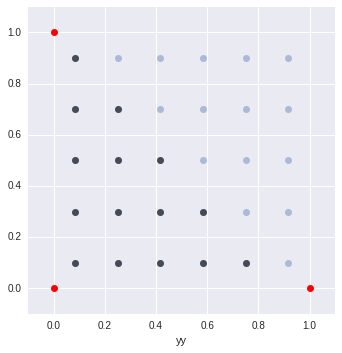

In [12]:
n, m = 6, 5
density = 10
x = np.arange(0+0.5, n+0.5)/n
y = np.arange(0+0.5, m+0.5)/m

xx, yy = np.meshgrid(x, y)

# Keep only grid points bellow the triangle sagitta
in_out = (xx + yy) < 1
fig, ax = plt.subplots()

ax.plot(xx.ravel(), yy.ravel(), 'o', alpha=0.4)

ax.plot(xx[in_out].ravel(), 
        yy[in_out].ravel(), 'ko', alpha=0.6)
ax.plot(0, 1, 'ro')
ax.plot(1, 0, 'ro')
ax.plot(0, 0, 'ro')

ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)

ax.set_xlabel('xx')
ax.set_xlabel('yy')

ax.set_aspect('equal')



In [13]:

specs = config.geometry.planar_sheet()
datasets, _ = generation.three_faces_sheet()

eptm = Sheet('3_sheet', datasets, specs)
geom.update_all(eptm)

base = ('face', 'srce', 'trgt')
base_edges = get_edge_bases(eptm, base)
f_grid = FaceGrid(base_edges, base)
f_grid.update_grid()

In [14]:
n_u, n_v = (subdiv.n_points for subdiv in f_grid.subdivs.values())
print('Face to source upcaster: {} subdivisions'.format(n_u))
print('Face to target upcaster: {} subdivisions'.format(n_v))
print('Total grid size: {}'.format(f_grid.n_points))

Face to source upcaster: 72 subdivisions
Face to target upcaster: 72 subdivisions
Total grid size: 288


In [15]:
points = f_grid.face_point_cloud(eptm.coords, eptm.dcoords)
f_grid.points.head()

,of_face_srce,of_face_trgt,up_face_srce,up_face_trgt,x,y,z
0,0.125,0.125,0,0,0.500,0.6495,0.0
1,0.375,0.125,0,0,0.375,0.4330,0.0
2,0.625,0.125,0,0,0.250,0.2165,0.0
4,0.125,0.375,0,0,0.625,0.4330,0.0
5,0.375,0.375,0,0,0.500,0.2165,0.0


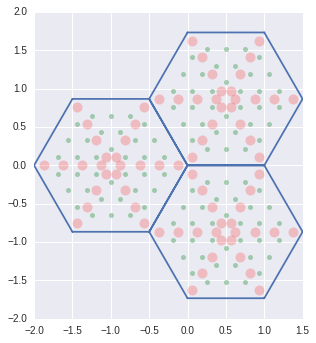

In [16]:
fig, ax = quick_edge_draw(eptm)
ax.plot(*f_grid.points[['x', 'y']].T.values,
        'o', ms=5., alpha=0.5)
ax.set_aspect('equal')

r_ij = f_grid.subdivs['face_srce'].edge_df[eptm.dcoords]
srce_pos = eptm.upcast_face(eptm.face_df[eptm.coords])
f_grid.subdivs['face_srce'].edge_point_cloud(srce_pos, r_ij)
points = f_grid.subdivs['face_srce'].points
ax.plot(*points[['x', 'y']].T.values,
        'ro', ms=10., alpha=0.2)


In [17]:
fig.savefig('../data/svg/3_cells_subdiv.svg')

In [28]:
eptm = monolayer.get_sub_sheet('apical')
base = ['face', 'srce', 'trgt']
base_edges = get_edge_bases(eptm, base)
f_grid = FaceGrid(base_edges, base, density=30, gamma=1)
f_grid.update_grid()
points = f_grid.face_point_cloud(eptm.coords, eptm.dcoords)


In [29]:
f_grid.points.head()

,of_face_srce,of_face_trgt,up_face_srce,up_face_trgt,x,y,z
0,0.019231,0.02,0,0,0.646431,0.063830,-0.790368
1,0.057692,0.02,0,0,0.641182,0.060123,-0.798136
2,0.096154,0.02,0,0,0.635933,0.056416,-0.805905
3,0.134615,0.02,0,0,0.630684,0.052709,-0.813674
4,0.173077,0.02,0,0,0.625435,0.049003,-0.821442


In [20]:
f_grid.points['rho'] = np.linalg.norm(f_grid.points[f_grid.of_cols], axis=1)

In [21]:
f_grid.points['theta'] = np.arctan2(*f_grid.points[f_grid.of_cols].values.T)

In [22]:
f_grid.points['rho'] = np.random.normal(0.6, 0.06,
                                        size=f_grid.points.rho.size)

f_grid.points[f_grid.of_cols[0]] = f_grid.points.eval('rho * cos(theta)')
f_grid.points[f_grid.of_cols[1]] = f_grid.points.eval('rho * sin(theta)')


In [23]:
points = f_grid.face_point_cloud(eptm.coords, eptm.dcoords)

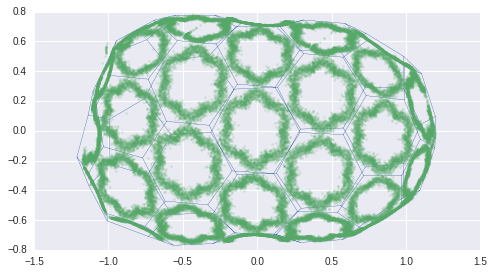

In [24]:
fig, ax = quick_edge_draw(eptm, ['z', 'x'], lw=0.2)

points = points[points['y'] > 0].copy()
#points += np.random.normal(scale=0.01, size=points.shape)

ax.plot(*points[['z', 'x']].T.values,
        '.', ms=5., alpha=0.2)
ax.set_aspect('equal')

In [28]:
filename = '../data/csv/ellipsoid_apical_faces'

write_storm_csv(filename, f_grid.points,
                split_by=None,#'segment',
                **csv_args)

In [62]:
filename = '../data/csv/ellipsoid_apical_actin'

write_storm_csv(filename, f_grid.points,
                split_by=None,#'segment',
                **csv_args)

In [64]:
base_t = ['cell', 'face', 'srce', 'trgt']
base_edges = get_edge_bases(monolayer, base_t)
f_grid = FaceGrid(base_edges, base_t, density=10)
f_grid.update_grid()
points = f_grid.face_point_cloud(eptm.coords, eptm.dcoords)

In [73]:
def face_point_cloud(self,
                     coords=['x', 'y', 'z'],
                     dcoords=['dx', 'dy', 'dz']):
    upcast = {}
    offsets = self.points[self.of_cols]
    for key, subdiv in self.subdivs.items():
        upcast[key] = subdiv.edge_df.loc[self.points['up_{}'.format(key)],
                                         coords+dcoords+['length',]].copy()
        upcast[key].reset_index(inplace=True)
        upcast[key]['offset'] = offsets['of_{}'.format(key)].values

    for u, du in zip(coords, dcoords):
        self.points[u] = (
            upcast[self.base[0]].eval(
                '{} + offset * {}'.format(u, du)).values +
            np.sum([upcast[other].eval('offset * {}'.format(du)).values
                    for other in self.base[1:]], axis=0))

    '''
    in_out = np.ones(self.points.shape[0], dtype=bool)
    for other in self.base[1:]:
        xx = upcast[self.base[0]]['offset'].values
        yy = upcast[other]['offset'].values
        in_out *= (xx + yy) < 1.

    self.points = self.points[in_out]
    '''
    return self.points[coords]


In [74]:
f_grid.points.shape

(1173433, 9)

In [75]:
points = face_point_cloud(f_grid)

In [76]:
points.shape


(1173433, 3)

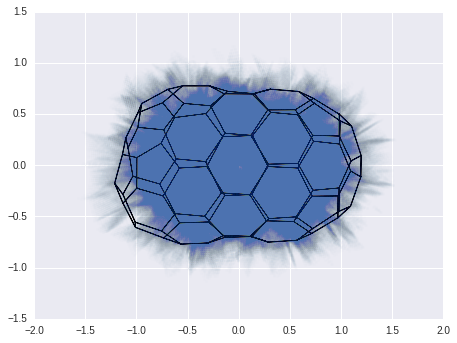

In [80]:
fig, ax = quick_edge_draw(eptm, coords=['z', 'x'], lw=1, c='k')
ax.plot(*points[['z', 'x']].T.values,
        '.', ms=5., alpha=0.01)

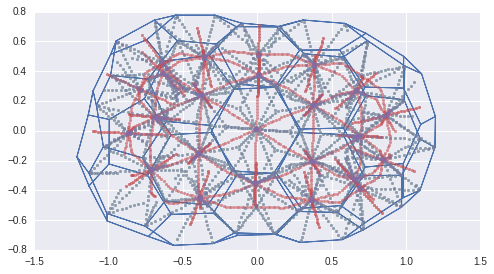

In [70]:
r_ij = f_grid.subdivs['cell_srce'].edge_df[monolayer.dcoords]
srce_pos = monolayer.upcast_cell(monolayer.cell_df[monolayer.coords])
f_grid.subdivs['cell_srce'].edge_point_cloud(srce_pos, r_ij)

r_ij = f_grid.subdivs['cell_trgt'].edge_df[monolayer.dcoords]
srce_pos = monolayer.upcast_cell(monolayer.cell_df[monolayer.coords])
f_grid.subdivs['cell_trgt'].edge_point_cloud(srce_pos, r_ij)

r_ij = f_grid.subdivs['cell_face'].edge_df[monolayer.dcoords]
srce_pos = monolayer.upcast_cell(monolayer.cell_df[monolayer.coords])
f_grid.subdivs['cell_face'].edge_point_cloud(srce_pos, r_ij)


fig, ax = quick_edge_draw(eptm, ['z', 'x'], lw=1)
for key in f_grid.subdivs:
    points = f_grid.subdivs[key].points[['x', 'y', 'z']]
    ax.plot(*points[points['y'] > 0][['z', 'x']].T.values,
            'o', ms=3., alpha=0.2)
    ax.set_aspect('equal')

In [71]:
points = pd.concat([f_grid.subdivs[key].points[['x', 'y', 'z']]
                    for key in f_grid.subdivs])

In [79]:
filename = '../data/csv/ellipsoid_points.csv'
write_storm_csv(filename, points,
                split_by=None,#'segment',
                **csv_args)

In [77]:
!ls -lht ../data/csv/

total 101M
-rw-r--r-- 1 guillaume guillaume  42M nov.   8 21:42 ellipsoid_faces.csv
-rw-r--r-- 1 guillaume guillaume  21M nov.   8 20:41 ellipsoid.csv
-rw-r--r-- 1 guillaume guillaume 238K nov.   6 19:43 ellipsoid_apical.csv
-rw-r--r-- 1 guillaume guillaume 2,8M nov.   6 19:26 ellipsoid_sagittal.csv
-rw-r--r-- 1 guillaume guillaume 2,8M nov.   6 19:26 ellipsoid_basal.csv
-rw-r--r-- 1 guillaume guillaume 4,0M oct.  28 10:43 ellipsoid_points_3.csv
-rw-r--r-- 1 guillaume guillaume 4,0M oct.  28 10:43 ellipsoid_points_2.csv
-rw-r--r-- 1 guillaume guillaume 8,6M oct.  28 10:43 ellipsoid_points_1.csv
-rw-r--r-- 1 guillaume guillaume  17M oct.  28 10:43 ellipsoid_points.csv
